# Project: Investigate the FBI NICS Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The data comes from the FBI's National Instant Criminal Background Check System. The **NICS** is used by to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. Orginal source on [Github](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/README.md).  

The data has been supplemented with state level data from census.gov.

### *Caveats* 
The **ncis data** set Contains number of firearm checks by month/state/type. However the reader should keep in mind the following before drawing conlusions:
- stats are the number of background checks, not the number of firearms sold.
- Laws regarding firearms purchase vary from state to state
- Firearms can be sold/pruchased privately, meaning without requiring a background check.
- Background checks are also performed for concealed carry permits.   
***>>one-to-one correlation cannot be made between a firearm background check and a firearm sale***

### *Notes on US Census data*
Contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.
### Questions  
1. Which states have had the highest growth in number of checks?
  - For these states, when did high increase/decrease happen?  
  - Were there any peaks? Are there any patterns?
  - Are there indeed more checks on permit in Kentucky, and is there every year an increase of checks in november as suggested here: [The Trace Article](https://www.thetrace.org/2015/11/black-friday-gun-sales-background-checks/)
   - What kind of guns are the most popular / increased the most?
2.  Are there any specific census data that is correlated to the increases of permit checks?  
    - Negatively?
    - Positively?
    
    
The dependant variable we will observe will be the number of checks on **handgun/long_gun/other/permit**, sum or mean, along the following independent variables: **year** (question 1a), **month** (question 1b), **type of gun** (question 1c), and of course **states**.  
Naturally, for the second question we will consider that all the **census data variables** are dependents variables that depend on the **state** independent variable.

In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling
### General Properties

In [2]:
# Load ncis data
ncis_df=pd.read_excel('gun_data.xlsx')
print ncis_df.shape #check shape
print ncis_df.dtypes #check types
ncis_df.head() #check first rows

(12485, 27)
month                         object
state                         object
permit                       float64
permit_recheck               float64
handgun                      float64
long_gun                     float64
other                        float64
multiple                       int64
admin                        float64
prepawn_handgun              float64
prepawn_long_gun             float64
prepawn_other                float64
redemption_handgun           float64
redemption_long_gun          float64
redemption_other             float64
returned_handgun             float64
returned_long_gun            float64
returned_other               float64
rentals_handgun              float64
rentals_long_gun             float64
private_sale_handgun         float64
private_sale_long_gun        float64
private_sale_other           float64
return_to_seller_handgun     float64
return_to_seller_long_gun    float64
return_to_seller_other       float64
totals                    

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


The ncis data looks clean. We won't need to parse values to force types for further processing.

In [3]:
#read csv file, we select only the first 65 rows because preparatory data wrangling showed that the bottom rows are just notes.
census_df=pd.read_csv('U.S. Census Data.csv', nrows= 65,decimal='.', thousands=',')
print census_df.shape
print census_df.dtypes
census_df.head()

(65, 52)
Fact              object
Fact Note         object
Alabama           object
Alaska            object
Arizona           object
Arkansas          object
California        object
Colorado          object
Connecticut       object
Delaware          object
Florida           object
Georgia           object
Hawaii            object
Idaho             object
Illinois          object
Indiana           object
Iowa              object
Kansas            object
Kentucky          object
Louisiana         object
Maine             object
Maryland          object
Massachusetts     object
Michigan          object
Minnesota         object
Mississippi       object
Missouri          object
Montana           object
Nebraska          object
Nevada            object
New Hampshire     object
New Jersey        object
New Mexico        object
New York          object
North Carolina    object
North Dakota      object
Ohio              object
Oklahoma          object
Oregon            object
Pennsylvania    

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


The census data provided is unfortunately not as clean as the ncis data set. All elements are unicode object (string). So we will need to convert them in float or int for further anaylsis purposes.   
The fact that states are in columns and dependent variables in rows is inconvenient. We will **'transpose'** the census dataframe.  
As mentionned in the introduction, variables have only one or two points (2010,2016). So the time range covered is actually 2010-2015. We will **filter the ncis data accordingly** so that comparisonmakes sense.  
Moreover rows and columns types formats are not consistent. Sometimes we have percentages with **%** symbol. Sometimes not. We have **$** symbols. We have **,** symbol for thousands. So we will definitely need to clean this data.  
We will also have to take car of the **flags** in the census data.  
Finally we will also need to get rid of the **fact note** column.

### Data Cleaning

#### Clean census data  
##### Remove Fact Note

In [4]:
census_df=census_df.drop('Fact Note', axis=1)

##### Transpose census dataframe

In [5]:
census_df=pd.melt(census_df, id_vars='Fact',var_name='State',value_name='Value')
census_df=census_df.pivot(index='State',columns='Fact',values='Value')

##### Parse each element

In [6]:
#defition of function to parse value of census_data
flags=['-','D','F','FN','NA','S','X','Z']
def parse_value(string):
    if string in flags: # take care of flags
        string=None
    else:
        if '%' in string: # remove % symbol
            string=float(string.replace('%',''))/100 # convert in float
        else: 
            string=string.replace('$','') # remove $ symbol
            string=string.replace(',','') # remove , symbol
            string=float(string) # convert in float
    return string
                       

census_clean=census_df.loc[:,census_df.columns != 'FIPS Code'].applymap(parse_value) # apply function to each element

#### Trim ncis data: keep year 2010 to 2016

In [7]:
#Trim ncis data to 2010 2016
ncis_df['year']=ncis_df['month'].apply(lambda x: int(float(x[:4]))) #add year column
ncis_df['M']=ncis_df['month'].apply(lambda x: int(float(x[-2:])))
ncis_2010=ncis_df[2010<=ncis_df['year']] #keep years within >= 2010
ncis_2010_2016=ncis_2010[ncis_2010['year']<=2016] #keep years <=2016

In [8]:
ncis_df.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals,year,M
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019,2017,9
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303,2017,9
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394,2017,9
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747,2017,9
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506,2017,9


<a id='eda'></a>
## Exploratory Data Analysis

### 1) Which states have had the highest growth in gun registrations?  
#### Visualize the evolution of permit checks per year for the most significant states

In [9]:
#Identify the 5 states with the most totals checks from 2010 to 2016-->top_states dictionnary
tot_check_per_states=dict() # dictionnary initialisation
for key,group in ncis_2010_2016.groupby(['state']):
    tot_check_per_states[key]=group.sum()['totals']
top_states={key:tot_check_per_states[key] for key in sorted(tot_check_per_states, key=tot_check_per_states.get,reverse=True)[:5]}    

#create function to plot the yearly value of a given column in ncis_df for the top_states
def plot_col(col_string):
    plot_data=ncis_2010_2016.groupby(['state','year']).sum()[col_string].unstack('state')
    for state in top_states:
        plt.plot(plot_data[state], label=state)
        plt.ylabel(col_string)
        plt.title('Yearly volume of '+col_string+' checks')
    
    return None

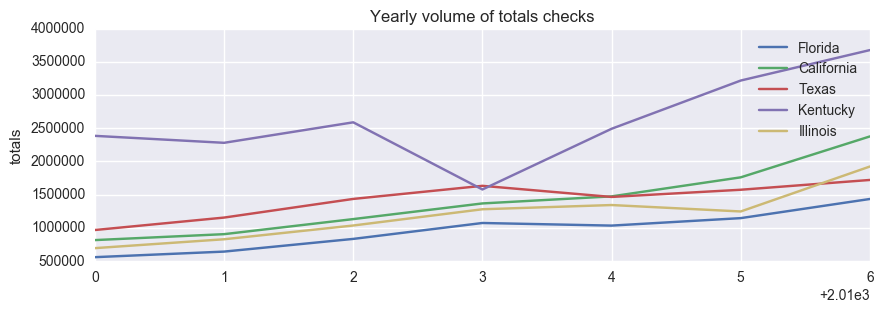

In [10]:
# create one figure with one linear plot describing the evolution of totals checks between 2010 and 2016 for the states with
# the biggest total checks during all these years
plt.figure(figsize=(10,3))
plot_col('totals')
plt.legend();

The 5 states with the highest permit checks are: Pennsylvania, Florida, California, Texas, Kentucky, Illinois..  
The number of checks performed in Kentucky is way higher than in the other states.
Can we find explainations when looking at the details per type?

#### Visualize details on the gun type

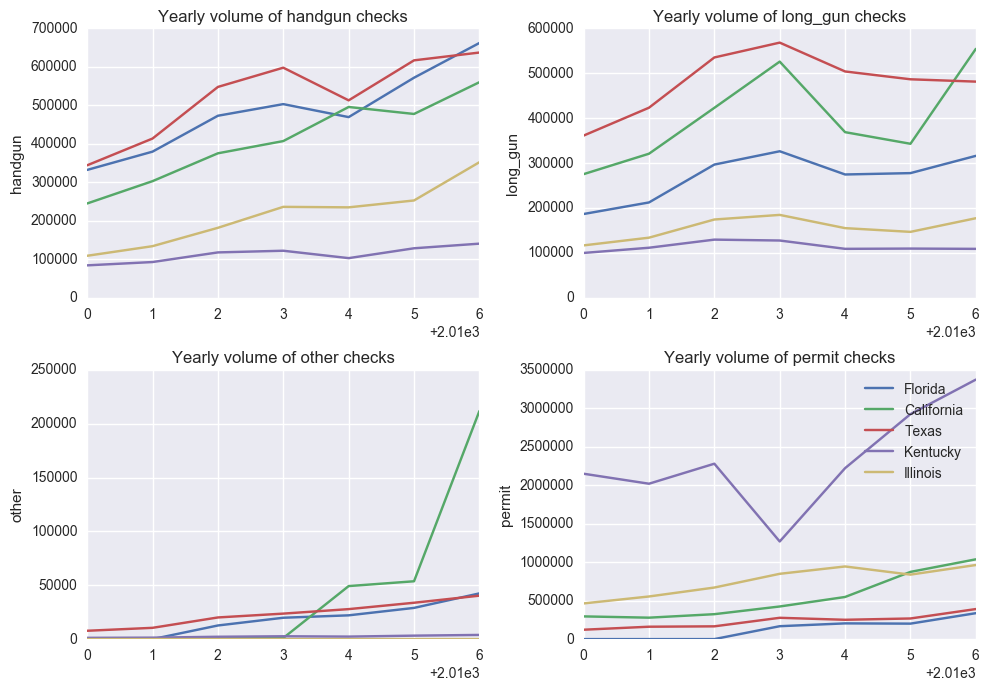

In [24]:
plt.figure(1)
plt.figure(figsize=(10,10))
plt.subplot(321)
plot_col('handgun')
plt.subplot(322)
plot_col('long_gun')
plt.subplot(323)
plot_col('other')
plt.subplot(324)
plot_col('permit')
plt.legend()
plt.tight_layout()

Globally it seems that the hierarchy observed on the totals checks is the same for the other types. We can spot the following exceptions though:  
- Texas is the 4th state as of totals checks in 2016 and was 1st on long guns only between 2010 and 2015. So people in TExas seems to be specifically fond of long guns compared to other states.
- On the permit chart, we can see that the number of checks in Kentucky is way higher than in the other states. So it confirms the saying of the article mentionned in the introduction:  
*'The FBI’s background check numbers come with caveats: As seen in the late February-early March 2014 bubble, many checks are for concealed carry permits, not actual gun sales. Kentucky runs a new check on each concealed carry license holder each month.'*  
- We observe also that there was a big increase of 'other' checks in California since 2013. I google without success for a definition of the different "types", so I can't explain what corresponds to this increase of type 'other'.


## Check if permit check in November if higher than the average

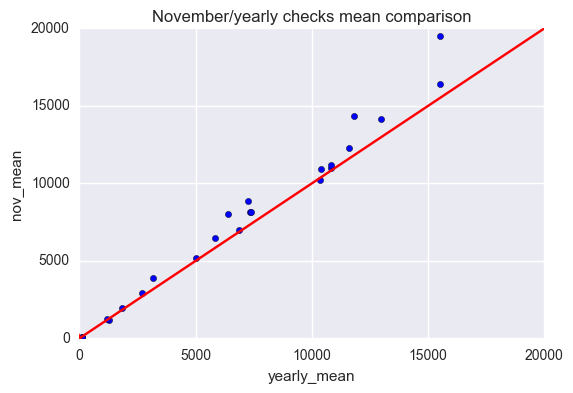

In [12]:
#get average
permit_means_all=ncis_2010_2016.groupby('state').mean()['totals']
permit_means_nov=ncis_2010_2016[ncis_2010_2016['month'].str.contains('-11')].groupby('state').mean()['totals']
permit_means_nov
blackfriday_df=pd.DataFrame({'yearly_mean':permit_means_all,'nov_mean':permit_means_nov})
#blackfriday_df.plot(x=0,y=1,kind='scatter')
fig,ax=plt.subplots()
ax.scatter(blackfriday_df['yearly_mean'],blackfriday_df['nov_mean'])
ax.plot([0,250000],[0,250000],marker='^',c='r')
ax.set_xlabel('yearly_mean')
ax.set_ylabel('nov_mean')
plt.axis([0,20000,0,20000])
plt.title('November/yearly checks mean comparison')
plt.show()


Here we observe that most of the states (each point is one state) are above the line y=x, meaning that in most of the states the november average is higher than the yearly average. It seems to confirm the Black Friday theory: the black friday in end of november boosts the sell of firearms, meaning that more checks are performed on this day.
Let's vizualize this differently: let's plot the mean of totals checks for one state (California for instance) keeping the month as time unit instead of grouping by year as done previously.

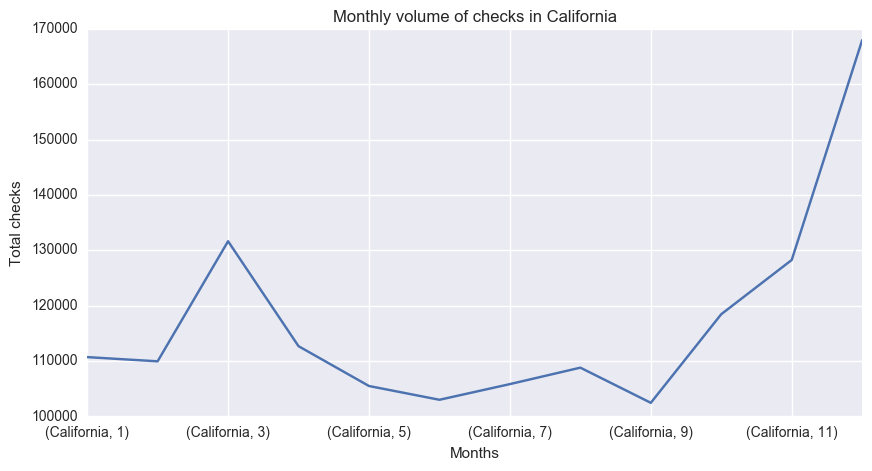

In [23]:
plot_data_california=ncis_2010_2016[ncis_2010_2016['state']=='California'].groupby(['state','M']).mean()['totals']#.unstack('state')
plt.figure(figsize=(10,5))
#print plot_data_california
plot_data_california.plot();
plt.xlabel('Months')
plt.ylabel('Total checks')
plt.title('Monthly volume of checks in California');

We clearly see that the monthly average is higher for the month of November and December: gun sales are likely to be boosted by Black Friday in November and Christmas in December, leading to a higher monthly average of checks.  
Could the March peak be linked to Easter?  
To check, we would need data including the day (not only month) on which the check was performed.

## 2. Compare to census data

First I'll define the **increase of checks** as the volume of total checks in 2016 divided by the volume of total checks in 2010. 
Second we will calculate the pearson correlation factor (to the increase of checks) for all the indicators in the census data (55)
Then we will plot the results on a histogram.
Finally for the census data identified as the most correlated, we will plot the following:
- point= one state
- x= increase of checks 
- y= selected census data

                                                    corrcoef census_data/check_increase
Housing units, April 1, 2010                                                   0.381488
Total employment, 2015                                                         0.380430
Total health care and social assistance receipt...                             0.380275
Households, 2011-2015                                                          0.378789
Nonminority-owned firms, 2012                                                  0.376845
Total retail sales, 2012 ($1,000)                                              0.376449
Housing units,  July 1, 2016,  (V2016)                                         0.375516
Population estimates base, April 1, 2010,  (V2016)                             0.372530
Population, Census, April 1, 2010                                              0.372521
Veterans, 2011-2015                                                            0.371322
Total employer establishments, 2

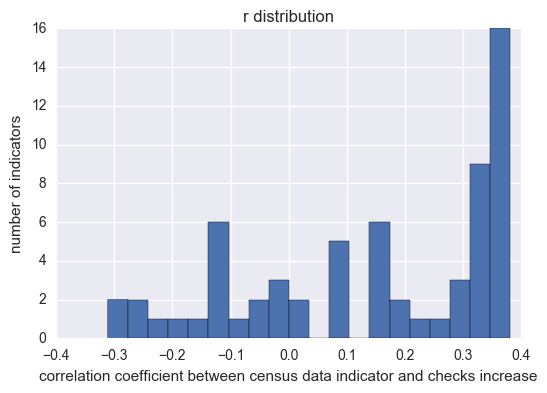

In [21]:
#1 get table of increase of firearm sells as defined per state
ncis_mean=ncis_2010_2016.groupby(['state','year']).sum()['totals'].unstack('year')
ncis_mean['increase']=ncis_mean[2016]/ncis_mean[2010]

#indentify state to dismiss, keep_states
increase_per_state=ncis_mean['increase'].replace(np.inf,np.nan).dropna()#drop nan and inf values
increase_per_state=increase_per_state[increase_per_state<60]#drop outliers
keep_states=increase_per_state.index
keep_states

#find correlation
#problem: district of Columbia and virgin islands are missing in census_clean. Need to join
census_and_increase=census_clean.join(pd.DataFrame(increase_per_state),how='inner')
corr_coef=pd.DataFrame({'corrcoef census_data/check_increase':census_and_increase.corr()['increase']})
corr_sorted=corr_coef.apply(lambda x: x.sort_values(ascending=False))
corr_sorted=corr_sorted[corr_sorted.index!='increase']
print corr_sorted
corr_sorted.hist(bins=20)
plt.title('r distribution')
plt.xlabel('correlation coefficient between census data indicator and checks increase')
plt.ylabel('number of indicators');

Some of the data is unsurprisingly positively correlated to the number of checks:
- population
- % of veterans
- % employment

The most negatively correlated data are indicators of how young he population is. It also makes sense: a person under 18 is not allowed to buy a firearm.

Let's focus on the % of person under 18.

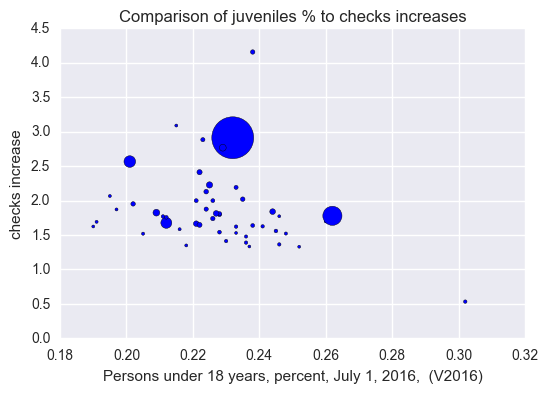

In [17]:
y=census_and_increase['increase']
x1=census_and_increase[corr_sorted.index[-3]]
s=census_and_increase['Population estimates, July 1, 2016,  (V2016)']
s_std=(s-s.mean())/s.std(ddof=1)
plt.ylabel('checks increase')
plt.xlabel(corr_sorted.index[-3])
plt.scatter(x1,y, s=10*np.exp(s_std))
plt.title('Comparison of juveniles % to checks increases');

<a id='conclusions'></a>
## Conclusions

We have been able to identify the states whose number of totals checks have increasedthe most in the past years:  
**Pennsylvania, Florida, California, Texas, Kentucky, Illinois**.  
We have been able to spot a specificity for Texas where more checks for long guns are performed, which could probably explained by the history or culture of this state. We observed peaks of checks in **november and december**.  
Finally we have been able to identify some demographics which indicators are positively to checks increases:
- population
- % of veterans
- employment rate

Or negatively correlated:
- % of juveniles
- % of people with a disability

The datasets analyzed have some limitations though. For instance:
- The NCIS data only give informations on checks per month. Having **additional data to know the checks per days** would make possible refining the observations on checks peaks: are there more checks on the particular Black Friday-day for instance?
- Having **data on the person actually "checked"** (age, income, ethnicity...) would also prevent us drawing wrong conclusions:  
This way we could for instance check whether veterans really own more guns.
- we limited the analysis to ncis data ranging from 2010 to 2016 and compared it to the census data, which gives for each indicator only one measure (2012 value, or 2010 value, or average of 2011-2015, etc...)
- when looking at the checks increases, we ignored the outliers.
- there were states with incomplete/missing data (the "flags" that we cleaned out).

Finally by having more information about the NCIS program and clear type definitions we could investigate deeper the differences between type of checks:
- What is the exact definition of type 'other'?
- What means permit recheck? How often has a permit to be rechecked: once per year? More than once per year? This would have an impact on the best time unit to choose for the analysis (year/month)?
- We didn't look at all at the type "rentals" or "returned" or "redemption" or "returned": to analyse the differences between states, a good knowledge of each state's laws would be required.